# Single-agent dynamic discrete choice estimation

Conroy Lau

This version: December 12, 2023

In [54]:
%pip install pandas --break-system-packages
%pip install matplotlib --break-system-packages
%pip install scipy --break-system-packages
%pip install cyipopt --break-system-packages


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [55]:
import os
import copy
import random
import array

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize
from numpy.linalg import norm
from numpy import ndarray
from cyipopt import minimize_ipopt

# General model setup

**Reference: Chapter 2.3.1**

The model's primitives are as follows.

- Set of alternatives: $\mathcal{J} \equiv \{1, \ldots, J\}$.
- State variables: $\mathcal{S}$, with observable component $x_t \in \mathcal{X}$ and unobservable component $\epsilon_t \equiv \{\epsilon_{j,t}\}_{j \in \mathcal{J}}$.
- The discount factor: $\beta$.
- Parameter that governs the utility function: $\theta$.
- As a result, the utility of choosing action $j$ at state $s_t$ is given by
  $$
    u(s_t, j; \theta) \equiv \overline{u}_j(x_t; \theta) + \epsilon_{j,t}.
  $$
- Parameter that governs the transition probabilities: $\varphi$.

# Rust (1987)

To illustrate the estimation methods, we will use the seminal Rust (1987) bus replacement model. 

We will mostly follow the original model specifications, with a few minor changes as follows.

- Set of alternatives: $\mathcal{J} \equiv \{1, 2\}$.
  - Choice 1: maintain bus engine.
  - Choice 2: replace bus engine.
- State variables:
  - Observable state variables: $x_t \in \{1, \ldots, X\}$ are the bus mileage. In this notebook, we set $X = 10$.
  - Unobservable state variables: $\epsilon_{jt}$ are assumed to follow a mean 0 T1EV distribution for any $j \in \mathcal{J}$ and $t$.
- Discount factor is assumed to be known. We set this as $\beta = 0.95$. Note that Rust (1987) uses $\beta = 0.9999$ in his main specification.
- The deterministic component of the utility (i.e., $\overline{u}_j(x_t; \theta)$) are parameterized as
  - Choice 1: $\overline{u}_1(x_t; \theta) = \theta_1 x_t$.
  - Choice 2: $\overline{u}_2(x_t; \theta) = \theta_2$.
  - We can interpret $\theta_1$ as the maintenance cost and $\theta_2$ as the replacement cost.
- The state transition matrix are given as follows.
  - When choice 1 is chosen, the transition matrix follows a multinomial distribution with $\varphi_1 = 0.3$ and $\varphi_2 = 0.6$. The transition matrix is given by:
    $$
    \begin{pmatrix}
        \varphi_1 & \varphi_2 & 1 - \varphi_1 - \varphi_2 & 0 & 0 & \cdots & 0 & 0 \\
        0 & \varphi_1 & \varphi_2 & 1 - \varphi_1 - \varphi_2 & 0 & \cdots & 0 & 0\\
        0 & 0 & \varphi_1 & \varphi_2 & 1 - \varphi_1 - \varphi_2 & \cdots & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\ 
        0 & 0 & 0 & 0 & 0 & \cdots & \varphi_1 & 1 - \varphi_1 \\ 
        0 & 0 & 0 & 0 & 0 & \cdots & 0 & 1
    \end{pmatrix}
    $$
  - When choice 2 is chosen, the states are reset to the initial state.
    $$
        \begin{pmatrix}
            1 & 0 & 0 & \cdots & 0 \\
            1 & 0 & 0 & \cdots & 0 \\
            \vdots & \vdots & \vdots & \ddots & \vdots \\
            1 & 0 & 0 & \cdots & 0 
        \end{pmatrix}
    $$

# Primitive

The object `dgp` stores the model primitives. 

Since we parameterize the utility functions completely by $\theta$, the object is going to store $\theta$ instead of the entire vector of utilities.

In [56]:
class dgp:
    """Creates the primitives of the dynamic discrete choice model.
        
        Parameters
        ----------
        β : `float`
            The discount factor.
        u : `nd_array`
            A matrix of utility over all the states and choices.
        f : `nd_array`
            Transition matrices for all the actions.
        J : `int`
            Number of actions.
        dx : `int`
            Number of states.
    """
    def __init__(
        self, 
        β: float,
        u: ndarray,
        F: ndarray,
        dx: int,
        J: int):
        
        self.β = β
        self.u = u
        self.F = F
        self.dx = dx
        self.J = J

Let's create the primitive object one-by-one. First, set $\beta = 0.9$, $\theta = (-0.2, 5)$, $|\mathcal{X}| = 10$ and $|\mathcal{J}| = 2$.

In [57]:
β = 0.95
θ = [-0.2, 5]
dx = 10
J = 2

Next, we can let `utility` be the deterministic part of the utility function that depends on our pre-defined parameters $\theta$, as well as the choice and state. Since the deterministic part of the utility is completely characterized by $\theta$, $x$, and $a$, we can compute them all in advance.

In [58]:
def utility(
    x: int, 
    a: int,
    θ: list):
    """Calculates the utility at a given action and state.
        
        Parameters
        ----------
            x : `int`
                State.
            a : `int`
                Action.
            θ : `list`
                Utility parameters.
    """
    
    if a == 0:
        u = x * θ[0] + θ[1]
    elif a == 1:
        u = 0
        
    return u

def utility_matrix(
    dx: int,
    J: int,
    θ: list):
    """Returns the matrix of utilites over all states and choices.
        
        Each row corresponds to a state.
        
        Each column corresponds to an action.
        
        Parameters
        ----------
            dx : `int`
                Number of states.
            J : `int`
                Number of actions.
            θ: `list`
                Utility parameters.
    """
    
    umat = np.zeros((dx, J))
    
    for a in range(J):
        for x in range(dx):
            umat[x, a] = utility(x, a, θ)
            
    return umat

umat = utility_matrix(dx, J, θ)

Now, let's create the transition matrix, i.e., $\mathrm{Pr}[dx_{t+1}|x_t, a_t = j, \varphi]$.

In [59]:
def transition(
    f: list,
    dx: int):
    """Creates the transition matrices.
        
       This function creates the transition matrices for both actions.
       The parameter `f` is only relevant for constructing the 
       transition matrix for the action j = 0.
       
       Parameters
       ----------
           f : `list`
               Parameters for the multinomial distribution for j = 0.
           dx : `int`
               Number of states.
    """
    
    # Initialize the two matrices
    F0 = np.zeros((dx, dx))
    F1 = copy.copy(F0)
    
    # Transition matrix for maintaining the engine
    for i in range(dx):
        if i < dx - 2:
            F0[i, i] = f[0]
            F0[i, i + 1] = f[1]
            F0[i, i + 2] = 1 - f[0] - f[1]
        elif i == dx - 2:
            F0[i, i] = f[0]
            F0[i, i + 1] = 1 - f[0]
        else:
            F0[i, i] = 1
    
    # Transition matrix for replacing the engine
    F1[:, 0] = 1
        
    return F0, F1

f = [0.3, 0.6]
F = transition(f, dx)

With the primitive objects defined, we can pass them to the `dgp` object as follows.

In [60]:
primitive = dgp(β, umat, F, dx, J)

# Bellman equation representation

**Reference: chapter 2.3.1.3**

- Let $\mathrm{Pr}[dx_{t+1}|x_t, a_t = j, \varphi]$ be the transition probability.
- Let $\overline{v}_j(x_t; \theta, \varphi)$ be the deterministic part of the value function for choosing choice $j$ at state $x_t$. Then, we can write
  $$
    \overline{v}_j(x_t; \theta, \varphi)
    = \overline{u}_j(x_t; \theta) + 
        \beta \int 
            \ln \left( \sum_{k \in \mathcal{J}}
                \exp\{\overline{v}_k(x_{t+1}; \theta, \varphi)\}
                \right) \mathrm{Pr}[dx_{t+1}|x_t, a_t = j, \varphi].
  $$
- The function `csvf_state` codes the choice-specific value function at state `x` with the given vector of value functions `V`.

# Fixed point representation


- Let $\overline{w}(x_t; \theta, \varphi) \equiv \ln(\sum_{k \in \mathcal{J}} \exp\{\overline{v}_k(x_k; \theta, \varphi)\})$.
- The fixed-point equation can be written as follows:
  $$
      \begin{pmatrix}
          \overline{v}_j(1; \theta, \varphi) \\ 
          \vdots \\
          \overline{v}_j(X; \theta, \varphi)
      \end{pmatrix}
      = 
      \begin{pmatrix}
          \overline{u}_j(1; \theta) \\ 
          \vdots \\ 
          \overline{u}_j(X; \theta)
      \end{pmatrix}
      + \beta \mathbf{P}[x_{t+1} | x_t, a_t; \varphi]
      \begin{pmatrix}
          \overline{w}(1; \theta, \varphi) \\ 
          \vdots \\ 
          \overline{w}(X; \theta, \varphi)
      \end{pmatrix},
  $$
  for each $j \in \mathcal{J}$.
- The above is a fixed-point equation. For a given guess of $\{\overline{w}(x; \theta, \varphi)\}_{x \in \mathcal{X}}$, one can update $\{\overline{v}_j(x; \theta, \varphi)\}_{j \in \mathcal{J}, x \in \mathcal{X}}$, and then update $\{\overline{w}(x; \theta, \varphi)\}_{x \in \mathcal{X}}$. One can update this via the fixed point iteration procedure.
- The function `vf` computes $\{\overline{w}(x; \theta, \varphi)\}_{x \in \mathcal{X}}$ for a given of $\{\overline{v}_j(x; \theta, \varphi)\}_{j \in \mathcal{J}, x \in \mathcal{X}}$.

In [61]:
def csvf_state(dgp, V, x):
    """Choice-specific value function at a particular state.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitive of the DDC model.
            V : `ndarray`
                A vector of value function.
            x : `int`
                State.
    """
    
    w = [dgp.u[x, a] + dgp.β * np.matmul(dgp.F[a][x, :], V) for a in range(dgp.J)]
    
    return w

def csvf(dgp, V):
    """Choice-specific value functions across all states.
    
        The function stacks the output of `csvf_state` over all states.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitive of the DDC model.
            V : `ndarray`
                A vector of value function.
    """
    
    wmat = np.zeros((dgp.dx, dgp.J))
    
    for x in range(dgp.dx):
        wmat[x, :] = csvf_state(dgp, V, x)    
    
    return wmat

def vf(w):
    """Computes the integrated value function.
    
        This function computes the integrated value function based on the 
        choice-specific value functions.
        
        Parameters
        ----------
            w : `ndarray`
                A vector of value functions.
    """
    
    wmax = np.amax(w)
    v = np.log(np.exp(w[:, 0] - wmax) + np.exp(w[:, 1] - wmax))
    v += wmax
    
    return v

With the value functions being coded, we can code the value function iteration procedure that find the fixed point $\{\overline{w}(x; \theta, \varphi)\}_{x \in \mathcal{X}}$. 

In [62]:
def vfi(dgp, ϵ = 1e-8):
    """Value function iteration.
        
        Takes the DGP object and returns the fixed-point of the value function equation.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitives of the DDC model.
            ϵ : `float`
                The tolerance level.
    """
    
    # Initialize - construct utility, transition matrices, and value function
    V0 = np.zeros(dgp.dx)

    # Iterate until convergence
    gap = 10000.
    iter = 1
    while gap > ϵ:
        w = csvf(dgp, V0)
        V1 = vf(w)
        gap = norm(V0 - V1)
        V0 = V1
        iter += 1
        
    return V0

We can get the value function using the model primitives as follows.

In [63]:
v_true = vfi(primitive)

# Conditional choice probability

- Under the assumption that $\epsilon_{jt}$ follows a mean 0 T1EV distribution, the conditional choice probability of choosing $j \in \mathcal{J}$ at state $x_t \in \mathcal{X}$ is
  $$
        \mathrm{Pr}[a_t = j | x_t; \theta, \varphi]
        = 
        \frac{\exp\{\overline{v}_j(x_t; \theta, \varphi)\}}{
        \sum_{k\in \mathcal{J}} \exp\{\overline{v}_k(x_t; \theta, \varphi)\}}.
  $$

In [64]:
def prob_from_dgp(dgp, V):
    """Conditional choice probability of maintaining the engine.
    
        Compute the conditional choice probability for maintaining the engine.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitives of the DDC model.
            V : `ndarray`
                A vector of value functions.
    """
    
    # Compute the choice probability and take the difference
    w = csvf(dgp, V)
    wmax = np.amax(w)
    wdifexp = np.exp(w - wmax)
    
    # Compute the conditional choice probability
    prob = np.zeros((dgp.dx, dgp.J))
    wsum = np.sum(wdifexp, axis = 1)
    for a in range(dgp.J):
        prob[:, a] = wdifexp[:, a]/wsum
        
    return prob

We can compute the probability of maintaining the engine as follows.

In [65]:
prob_true = prob_from_dgp(primitive, v_true)
prob_maintain_true = prob_true[:, 0]

# Simulate data

With the functions for the value function and the primitives of the models defined, we are able to simulate data from it. 

Let there be $N$ (independent) buses and $T$ periods. The following function simulates data and stores the results as a dataframe.

In [66]:
def draw(dgp, V, N, T):
    """Simulate Rust data.
    
        Draw data with N buses and T periods based on the `dgp` and `ddc` objects.
        
        Parameters
        ----------
            dgp : `dgp`
                The primitives of the DDC model.
            V : `ndarray`
                A vector of value functions.
            N : `int`
                Number of buses.
            T : `int`
                Number of periods.
    """
    action = [] #np.zeros((N, T - 1))
    state = []
    ids = []
    ts = [] 
    
    for i in range(N):
        ai = np.zeros(T)
        si = np.zeros(T, dtype = int)
        si[0] = 0
        ai[0] = None
        
        for t in range(T - 1):
            # Update state
            uf = np.random.uniform()
            if (t > 0) & (ai[t] == 0) | (t == 0):
                st = si[t]
                f0 = dgp.F[0][st]
                if si[t] < dgp.dx - 2:
                    if uf < f0[st]:
                        si[t + 1] = si[t]
                    elif (uf >= f0[st]) & (uf < (f0[st] + f0[st + 1])):
                        si[t + 1] = si[t] + 1
                    else:
                        si[t + 1] = si[t] + 2
                elif si[t] == dgp.dx - 2:
                    if uf < f0[st]:
                        si[t + 1] = si[t]
                    else:
                        si[t + 1] = si[t] + 1
                else:
                    si[t + 1] = si[t]
            elif ai[t] == 1:
                si[t + 1] = 0
                
            # Compute utility at this state and choose utiliy-maximizing action
            us = csvf_state(dgp, V, int(si[t + 1]))
            us += np.random.gumbel(-.577, size = dgp.J)
            ai[t + 1] = np.argmax(us)
            
        # Append data
        state = np.concatenate((state, si))
        action = np.concatenate((action, ai))
        ids = np.concatenate((ids, np.repeat(i + 1, T)))
        ts = np.concatenate((ts, range(0, T)))

    df = pd.DataFrame({'i': ids, 't': ts, 'action': action, 'state': state})
    
    return df

Let's simulate data with 30 periods and 30 buses.

In [67]:
N = 30
T = 30

np.random.seed(1)
df = draw(primitive, v_true, N, T)

Let's estimate the probability of maintaining the engine based on the simulated data. The following function estimates the probability using the simple frequency estimator.

In [68]:
def estimate_ccp(data, dgp):
    """Estimates conditional choice probability of maintaining the engine
        This is estimated using the simple frequency estimator.
        
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    phat = np.zeros((dgp.dx, dgp.J))
    
    for x in range(dgp.dx):
        data_x = data.loc[(data.t > 0) & (data.state == x)]
        for a in range(dgp.J):
            phat[x, a] = np.mean(data_x.action == a)
    
    return phat

In [69]:
phat = estimate_ccp(df, primitive)
phat_maintain = phat[:, 0]

Let's compare the probability of choosing engine replacement from the simulated data against the probability specified by the model primitives.

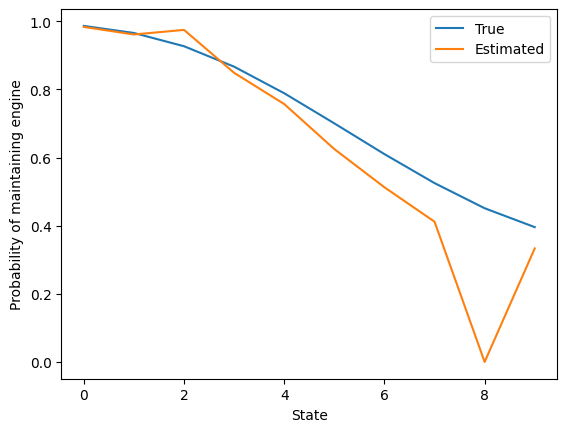

In [70]:
fig, ax = plt.subplots()  
xs = range(primitive.dx)
ax.plot(xs, prob_maintain_true, label = 'True')
ax.plot(xs, phat_maintain, label = 'Estimated')
ax.set_xlabel('State') 
ax.set_ylabel('Probability of maintaining engine')
ax.legend()

# Estimation 1: Nested fixed-point algorithm

The nested fixed-point algorithm (NFXP) contains two loops. 
- **Outer loop**: For a given vector of value functions $V$, find $\widehat\theta$ that maximizes the likelihood.
- **Inner loop**: For a given utility parameter $\theta$, find $\widehat{V}$ the fixed-point.

Here, we estimate the transition matrix first, and then take it as given when running NFXP. Hence, we will be maximizing the (partial) log-likelihood instead of the full log-likelihood.

The function to estimate the transition matrix is as follows.

In [71]:
def estimate_transition_maintain(data, dgp):
    """Estimated the transition matrix for maintaining bus engine.
        
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    # Estimate Δstate for each of the states
    data_tmp = copy.copy(data)
    data_tmp['state_shift'] = data_tmp.groupby('i')['state'].shift(-1)
    data_tmp['state_dif'] = data_tmp['state_shift'] - data_tmp['state']
    data_sub = data_tmp.loc[(data_tmp.action == 0) & (data_tmp.t != max(data_tmp.t))]
    
    # Construct the transition matrix for a = 0
    unique_dif = pd.unique(data_sub['state_dif'])
    probs = np.zeros(len(unique_dif))
    for idu, val in enumerate(unique_dif):
        probs[idu] = np.mean(data_sub['state_dif'] == val)
        
    return probs


def estimate_transition(data, dgp):
    """Estimate the transition matrix based on the data.
    
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    # Estimate the parameters of the multinomial distribution
    maintain_prob = estimate_transition_maintain(data, dgp)
    
    # Construct the transition matrix
    transition_mat = transition(maintain_prob[range(dgp.J)], dgp.dx)
    
    return transition_mat

The estimation procedure is coded as follows.

In [91]:
def likelihood_nfxp(θ, data, dgp):
    """The likelihood function for NFXP.
        
        Parameters
        ----------
        θ : `list`
            The utility parameters.
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    # Get value functions from parameters
    dgp_tmp = copy.copy(dgp)
    dgp_tmp.u = utility_matrix(dgp.dx, dgp.J, θ)
    V = vfi(dgp_tmp)
    
    # Get the choice probabilities
    pr0 = prob_from_dgp(dgp_tmp, V)
        
    # Compute likelihood of data
    l = likelihood(data, dgp_tmp, pr0)
    
    return l

def likelihood(data, dgp, prob):
    """The likelihood function with the given choice probability
    
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
        prob : `ndarray`
            A matrix of choice probabilities.
    """
    
    # Compute likelihood of data
    N = int(max(data.i))
    T = int(max(data.t))
    l = 0.
    
    for i in range(N):
        for t in range(T):
            condn = (data.i == i + 1) & (data.t == t + 1)
            a = int(data.loc[condn].action.iloc[0])
            x = int(data.loc[condn].state.iloc[0])
            
            # Append the right probability depending on the choice and state
            l += np.log(prob[x, a]) 
            
    return -l/(N*T)

def nested_fixed_point(data, dgp):
    """The nested fixed-point algorithm.

        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    def ll(x):
        return likelihood_nfxp(x, data, dgp)
    θ = minimize(ll, [0.1, 0.1])
    
    return θ

Note that the procedure `nested_fixed_point` takes the transition matrices in `dgp` as given. As a result, we need to estimate the transition matrix using the given data before passing it to the function.

In [73]:
# Estimate transition matrix
primitive_hat = copy.copy(primitive)
primitive_hat.F = estimate_transition(df, primitive)

Let's examine the solution of the NFXP.

In [92]:
# Estimate the parameters
nfxp_out = nested_fixed_point(df, primitive_hat)
print(nfxp_out.x)

[-0.26989967  5.81706559]


We can also compare the probability using the parameters implied by the NFXP against the true probabilities.

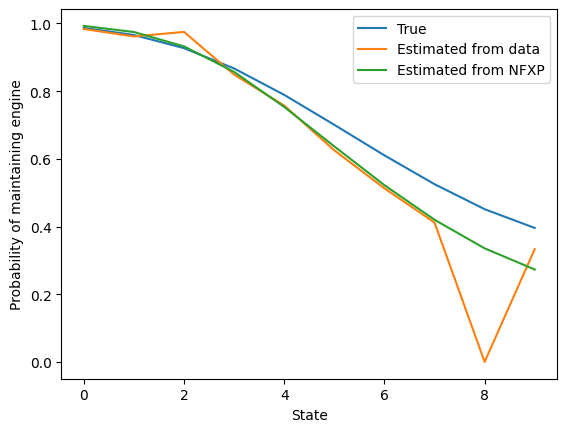

In [93]:
primitive_nfxp = copy.copy(primitive_hat)
primitive_nfxp.u = utility_matrix(dx, J, nfxp_out.x)
v_nfxp = vfi(primitive_nfxp)
p_nfxp = prob_from_dgp(primitive_nfxp, v_nfxp)

fig, ax = plt.subplots()  
xs = range(primitive.dx)
ax.plot(xs, prob_maintain_true, label = 'True')
ax.plot(xs, phat_maintain, label = 'Estimated from data')
ax.plot(xs, p_nfxp[:, 0], label = 'Estimated from NFXP')
ax.set_xlabel('State') 
ax.set_ylabel('Probability of maintaining engine')
ax.legend()

# Estimation 2: Conditional choice probability inversion

**Reference: Chapter 2.3.2**

- Let $\widehat{\text{Pr}}[a_t = j|x_t]$ and $\widehat{v}_j(x_t)$ be the sample analogue of $\text{Pr}[a_t = j|x_t; \theta, \varphi]$ and $\overline{v}_j(x_t; \theta, \varphi)$ respectively. As noted in footnote 20, we do not index the sample analogue by $\theta$ and $\varphi$ because we estimate them from data.
- Then, the sample analogue of the conditional choice probability can be written as
  $$
    \widehat{\mathrm{Pr}}[a_t = j | x_t]
    = \frac{\exp(\widehat{v}_j(x_t))}{\sum_{k \in \mathcal{J}} \exp(\widehat{v}_k(x_t))}.
  $$
- Let $J$ be the reference choice, or outside option, in which we normalize $\overline{v}_J(x_t; \theta, \varphi) = 0$. Then, using the above sample analogue representation, we can write
  $$
    \ln \left(
        \frac{\widehat{\text{Pr}}(a_t = j|x_t)}{\widehat{\text{Pr}}(a_t = J|x_t)}
        \right)
        = \widehat{v}_j(x_t) - \underbrace{\widehat{v}_J(x_t)}_{\text{$=0$ by normalization}}.
  $$
- As a result, the maximum-likelihood estimator would proceed with the objective function
  $$
    \sum_t \sum_{j \in \mathcal{J}} 
      \mathbf{1}(a_t = j|x_t)
      \log \left\{
        \frac{\exp(\overline{\widehat{v}}_j(x_t; \theta, \varphi))}{\sum_{k \in \mathcal{J}} \exp( \overline{\widehat{v}}_k(x_t; \theta, \varphi))}
      \right\}
  $$
  where
  $$
    \overline{\widehat{v}}_j(x_t; \theta, \varphi)
      - \overline{\widehat{v}}_J(x_t; \theta, \varphi)
      = \overline{u}_j(x_t; \theta) - \overline{u}_J(x_t; \theta)
      + \beta \int \ln \left(
          \sum_{k \in \mathcal{J}}
              \exp(\widehat{v}_k(x_{t+1}))
          \right)
          \left\{
            \mathrm{Pr}(dx_{t+1}|x_t, a_t = j, \varphi)
            - \mathrm{Pr}(dx_{t+1}|x_t, a_t = J, \varphi)
          \right\}.
  $$

The following function estimates $\widetilde{v}_a(x)$ based on the choice probability being estimated from before.

In [76]:
def csvf_from_ccp(dgp, phat):
    """Estimates choice-specific value function from choice probabilities.
    
        The choice-specific value function of the last action is normalized to 0.
                
        Parameters
        ----------
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
    """

    # implement this function

Using the above function, one can implement the two-step method by maximizing the likelihood.

In [77]:
def likelihood_two_step_ccp(θ, data, dgp, phat):
    """The likelihood function for the two-step method.
        
        Parameters
        ----------
        θ : `list`
            The utility parameters.
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
    """

    # implement this function
    
def two_step_ccp(data, dgp):
    """The two-step CCP approach.

        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
    """
    
    # implement this function

# Estimation 3: Nested pseudo-likelihood

**Reference: chapter 2.3.3**

- Consider a slightly different notion of value function here together with the assumption that the error term follows a mean-0 T1EV distribution:
  $$
    \overline{\overline{v}}(x_t; \theta, \varphi)
    = \sum_{j \in \mathcal{J}}
        \text{Pr}(a_t = j|x_t; \theta, \varphi)
        \left\{
            \overline{u}_j(x_t; \theta) 
            - \ln \mathrm{Pr}(a_t = j|x_t; \theta, \varphi)
            + \beta \sum_{x' \in \mathcal{X}}
                \overline{v}(x_{t+1} = x'; \theta, \varphi)
                \text{Pr}(x_{t+1} = x'|x_t, a_t = j; \varphi)
        \right\}.
  $$

- By stacking the terms over the states and actions, we obtain a matrix equation where
  $$
    \overline{\overline{v}}(x_t; \theta, \varphi)
    = [\mathbf{I} - \beta \mathbf{P}(x_{t+1}|x_t; \theta, \varphi)]^{-1}
    \mathbf{w}(a_t, x_t; \theta, \varphi),
  $$
  where
    - $\mathbf{w}(a_t, x_t; \theta, \varphi)
        := \begin{pmatrix}
            \mathbf{p}(a_t|1; \theta, \varphi)'(\overline{\mathbf{u}}(x_t = 1; \theta) - \ln \mathbf{p}(a_t|1; \theta, \varphi) \\ 
            \mathbf{p}(a_t|2; \theta, \varphi)'(\overline{\mathbf{u}}(x_t = 2; \theta) - \ln \mathbf{p}(a_t|2; \theta, \varphi) \\ 
            \vdots \\
            \mathbf{p}(a_t|X; \theta, \varphi)'(\overline{\mathbf{u}}(x_t = X; \theta) - \ln \mathbf{p}(a_t|X; \theta, \varphi) 
        \end{pmatrix}$.
    - $\mathbf{p}(a_t|1, \theta, \varphi)
          :=
          \begin{pmatrix}
              \text{Pr}(1|1; \theta, \varphi) \\ 
              \text{Pr}(2|1; \theta, \varphi) \\
              \vdots \\ 
              \text{Pr}(J|1; \theta, \varphi)
          \end{pmatrix}$.
    - $\mathbf{P}(x_{t+1}|1, a_t; \varphi)
          :=
          \begin{pmatrix}
             \text{Pr}(1|1,1;\varphi) & 
             \text{Pr}(2|1,1;\varphi) & 
             \cdots & 
             \text{Pr}(X|1,1;\varphi) \\ 
             \text{Pr}(1|1,2;\varphi) & 
             \text{Pr}(2|1,2;\varphi) & 
             \cdots & 
             \text{Pr}(X|1,2;\varphi) \\
             \vdots & \vdots & \ddots & \vdots \\
             \text{Pr}(1|1,J;\varphi) & 
             \text{Pr}(2|1,J;\varphi) & 
             \cdots & 
             \text{Pr}(X|1,J;\varphi) 
          \end{pmatrix}
          $.
- The $K$-stage policy iteration estimator works as follows. Let $\mathbf{P}^{K-1}(a_t|x_t; \theta, \widehat{\varphi})$ be the guess of $\mathbf{P}$ in the $(K-1)$-th step. With the given guess, we want to obtain
  $$
    \widehat{\theta}^K
    = \text{arg max}_{\theta} \prod_i
        \mathcal{L}_i\left(
            \Psi(
                \mathbf{P}^{K-1}(a_t|x_t; \theta, \widehat\varphi)
            )
        \right),
  $$
  where $\mathcal{L}_i(\cdot)$ denotes the likelihood induced by the argument. The second step is to update $\mathbf{P}$ via
  $$
    \mathbf{P}^K(a_t|x_t;\theta,\widehat{\varphi})
    = \Psi(\mathbf{P}^{K-1}(a_t|x_t; \widehat{\theta}^K, \widehat{\varphi}).
  $$

In [89]:
def estimate_unconditional_transition(dgp, phat):
    """Estimate the unconditional transition matrix.
    
        Parameters
        ----------
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
    """

    P = np.zeros((dgp.dx, dgp.dx))
    for a in range(dgp.J):
        P += dgp.F[a] * np.transpose([phat[:, a] for i in range(dgp.dx)])# Note: this is incorrect???
        
    return P

def nested_pseudo_likelihood_k(dgp, phat):
    """Step k of the nested pseudo likelihood method.
    
        Parameters
        ----------
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
    """
        
    # Get the "w" function
    epsilon = 1e-10  # or a similarly small number
    what = np.sum(phat * (dgp.u - np.log(phat + epsilon)), axis=1)
    
    # Compute \bar{V} for the value function
    I = np.eye(dgp.dx)
    P = estimate_unconditional_transition(dgp, phat)
    inv_factor = np.linalg.inv(I - dgp.β * P)
    vbar = inv_factor @ what
    
    # Recover the choice-specific value function
    pnew = prob_from_dgp(dgp, vbar)
    
    return pnew


The likelihood for the nested pseudo likelihood method uses the updated $\widehat P^K$ to construct an updated $\widehat V^K$, which is subsequently used to construct the choice probability in the objective. 

In [79]:
def likelihood_npl(θ, data, dgp, phat):
    """The likelihood function for the two-step method.
        
        Parameters
        ----------
        θ : `list`
            The utility parameters.
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
    """
    # Get the utility function based on the parameters
    dgp_tmp = copy.copy(dgp)
    dgp_tmp.u = utility_matrix(dgp.dx, dgp.J, θ)
    
    # Get the probability
    pk = nested_pseudo_likelihood_k(dgp_tmp, phat)
        
    # Compute likelihood of data
    l = likelihood(data, dgp_tmp, pk)
    
    return l

def nested_pseudo_likelihood(data, dgp, phat, K):
    """Run the nested pseudo likelihood method with K iterations.
        
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
        phat : `ndarray`
            The matrix of estimated choice probabilities.
        K : `int`
            The number of iterations for the nested pseudo likelihood method.
    """
    
    pk = copy.copy(phat)
    dgpk = copy.copy(dgp)
    
    for i in range(K):
        
        def ll(x):
            return likelihood_npl(x, data, dgpk, pk)
        θiter = minimize(ll, [0.1, 0.1]).x
        
        dgpk.u = utility_matrix(dgp.dx, dgp.J, θiter)
        
        pk = nested_pseudo_likelihood_k(dgpk, pk)
        
        if i == K - 1:
            return pk, θiter

Let's see the result when we iterate it for $K=10$ times.

In [90]:
K = 10
npl_out = nested_pseudo_likelihood(df, primitive_hat, phat, 10)
npl_out[1]

/var/folders/82/sbnh68fj6qb2y53g99j9bvf80000gn/T/ipykernel_3263/446637203.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  a = int(data.loc[condn].action)
/var/folders/82/sbnh68fj6qb2y53g99j9bvf80000gn/T/ipykernel_3263/446637203.py:49: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  x = int(data.loc[condn].state)


array([-0.26990158,  5.81712413])

# Estimation 4: MPEC

**Reference: chapter 2.3.1.4**

The problem can be implemented as a constrained optimization problem, where we maximize the likelihood subject to the value functions as constraints.

In [81]:
def mpec(data, dgp):
    # Initial parameters
    dx = dgp.dx + 2
    
    # Define objective
    def mpec_objective(x):
        θ = x[range(2)]
        v = x[range(2, dx)]
        
        dgp_tmp = copy.copy(dgp)
        dgp_tmp.u = utility_matrix(dgp.dx, dgp.J, θ)

        prob = prob_from_dgp(dgp_tmp, v)
        ll = likelihood(data, dgp, prob)
        return ll
    
    # Define equality constraints
    def mpec_value_constraints(x):
        v = x[range(2, dx)]
        return v - vf(csvf(dgp, v))
    
    # Define lower bound on value functions
    def mpec_lb_constraint(x):
        v = x[range(2, dx)]
        return v
        
    # Dictionary of constraints
    c = [ {'type': 'eq', 'fun': mpec_value_constraints},
          {'type': 'ineq', 'fun': mpec_lb_constraint}]
        
    # Initial point
    x0 = np.concatenate((np.array([.1, .1]), np.zeros(dgp.dx)))
    
    return minimize_ipopt(mpec_objective, \
                          x0 = x0, \
                          constraints = c,
                          options = {"acceptable_tol": 1e-8})

In [82]:
r = mpec(df, primitive_hat)
print(r.x[range(2)])

/var/folders/82/sbnh68fj6qb2y53g99j9bvf80000gn/T/ipykernel_3263/446637203.py:48: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  a = int(data.loc[condn].action)
/var/folders/82/sbnh68fj6qb2y53g99j9bvf80000gn/T/ipykernel_3263/446637203.py:49: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  x = int(data.loc[condn].state)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[-0.3471988   5.43168883]


Gradients can be passed explicitly to the above solver to reduce computational time.

# Summary

Finally, let's collect everything in one function.

In [83]:
def solve_ddc(data, dgp, method, K):
    """Solves a DDC model.
        
        Parameters
        ----------
        data : `DataFrame`
            The data that contains the actions and states.
        dgp : `dgp`
            The primitives of the DDC model.
        method : `string`
            The solution method.
        K : `int`
            The number of iterations for the nested pseudo likelihood method.
            This argument is used only when we use the "npl" method.
    """
    
    if method == "nfxp":
        out = nested_fixed_point(data, dgp)
    elif method == "two step":
        out = two_step_ccp(data, dgp)
    elif method == "npl":
        phat = estimate_ccp(data, dgp)
        out = nested_pseudo_likelihood(data, dgp, phat, K)
    elif method == "mpec":
        out = mpec(data, dgp)
    return out

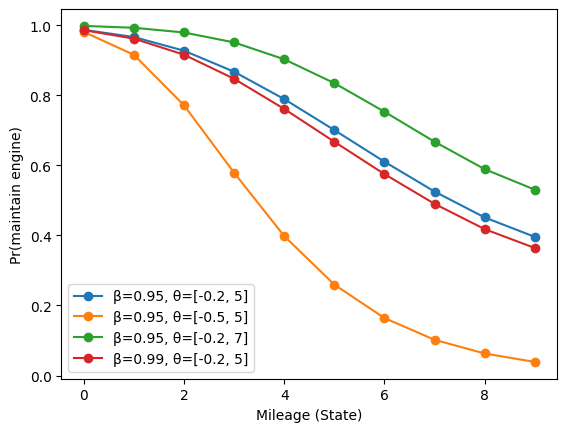

In [84]:
# Example: try different parameter combinations
params = [
    {"beta": 0.95, "theta": [-0.2, 5]},
    {"beta": 0.95, "theta": [-0.5, 5]},   # lower maintenance cost (more negative theta1)
    {"beta": 0.95, "theta": [-0.2, 7]},   # higher replacement cost (theta2)
    {"beta": 0.99, "theta": [-0.2, 5]},   # more patient agent
]

fig, ax = plt.subplots()
xs = np.arange(primitive.dx)

for p in params:
    beta = p["beta"]
    theta = p["theta"]
    # Create a new primitive with these parameters.
    umat_new = utility_matrix(dx, J, theta)
    prim_new = dgp(beta, umat_new, F, dx, J)
    V_new = vfi(prim_new)
    prob_new = prob_from_dgp(prim_new, V_new)
    # Here, action 0 is "maintain the engine."
    ax.plot(xs, prob_new[:, 0], marker='o', label=f"β={beta}, θ={theta}")

ax.set_xlabel("Mileage (State)")
ax.set_ylabel("Pr(maintain engine)")
ax.legend()
plt.show()

In [96]:
def csvf_from_ccp(dgp, phat):
    """
    Recover the choice-specific value functions from the estimated CCPs.
    We take the last alternative (j = dgp.J - 1) as the reference, so that
    v_ref(x) = 0 and for j != ref, v(x,j) = ln(phat(x,j)) - ln(phat(x,ref)).
    """
    v_est = np.zeros((dgp.dx, dgp.J))
    ref = dgp.J - 1
    for x in range(dgp.dx):
        for j in range(dgp.J):
            if j != ref:
                epsilon = 1e-10  # A small constant
                v_est[x, j] = np.log(phat[x, j] + epsilon) - np.log(phat[x, ref] + epsilon)
            else:
                v_est[x, j] = 0.0
    return v_est

def likelihood_two_step_ccp(theta, data, dgp, phat):
    """
    Likelihood function for the two-step CCP inversion method.
    Given theta, compute the model-implied differences in the choice-specific
    value functions and then compute the likelihood based on the softmax form.
    """
    # Compute the flow utility matrix under theta.
    u_mat = utility_matrix(dgp.dx, dgp.J, theta)
    ref = dgp.J - 1

    # First, recover the estimated value functions from the nonparametric CCPs.
    v_hat = csvf_from_ccp(dgp, phat)
    
    # For each state, compute the model-implied difference in value functions:
    # We have
    #   v_model(x,j) = u(x,j) - u(x,ref) + β * [transition term],
    # where the transition term is computed as:
    v_model = np.zeros((dgp.dx, dgp.J))
    for x in range(dgp.dx):
        for j in range(dgp.J):
            if j == ref:
                v_model[x, j] = 0.0
            else:
                transition_diff = 0.0
                # Here we sum over next states using the known transition matrices.
                for x_next in range(dgp.dx):
                    # Using v_hat, we compute the integrated continuation value
                    w_val = np.log(np.sum(np.exp(v_hat[x_next, :])))
                    # Difference in transition probabilities between alternative j and ref.
                    transition_diff += (dgp.F[j][x, x_next] - dgp.F[ref][x, x_next]) * w_val
                v_model[x, j] = u_mat[x, j] - u_mat[x, ref] + dgp.β * transition_diff

    # Given the model-implied differences v_model, we can compute predicted CCPs via softmax.
    predicted_probs = np.zeros((dgp.dx, dgp.J))
    for x in range(dgp.dx):
        exp_vals = np.exp(v_model[x, :])
        predicted_probs[x, :] = exp_vals / np.sum(exp_vals)
    
    # Finally, compute the (negative) log-likelihood using the data.
    ll = likelihood(data, dgp, predicted_probs)
    return ll

def two_step_ccp(data, dgp):
    """
    Two-step CCP inversion estimator:
    (1) Estimate CCPs from the data.
    (2) Maximize the likelihood (which uses the CCP inversion) with respect to theta.
    """
    phat = estimate_ccp(data, dgp)
    result = minimize(lambda theta: likelihood_two_step_ccp(theta, data, dgp, phat),
                      x0=[0.1, 0.1])
    return result.x

Estimated theta (two-step): [-0.25821436  4.99855898]


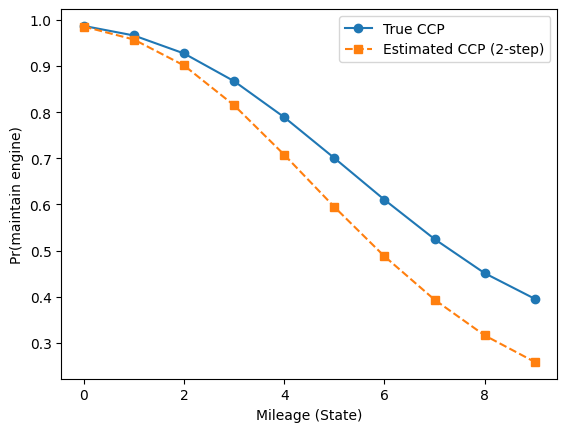

In [97]:
# Set true parameters
theta_true = [-0.2, 5]
beta_true = 0.95
umat_true = utility_matrix(dx, J, theta_true)
primitive_true = dgp(beta_true, umat_true, F, dx, J)
v_true = vfi(primitive_true)
prob_true = prob_from_dgp(primitive_true, v_true)

# Simulate data:
N = 30; T = 30
np.random.seed(1)
df_sim = draw(primitive_true, v_true, N, T)

# Estimate using the two-step CCP inversion method:
theta_est = two_step_ccp(df_sim, primitive_true)
print("Estimated theta (two-step):", theta_est)

# Using the estimated theta, compute the implied CCP's:
umat_est = utility_matrix(dx, J, theta_est)
primitive_est = dgp(beta_true, umat_est, F, dx, J)
v_est = vfi(primitive_est)
prob_est = prob_from_dgp(primitive_est, v_est)

# Plot the probabilities of maintaining (action 0)
fig, ax = plt.subplots()
xs = np.arange(dx)
ax.plot(xs, prob_true[:, 0], 'o-', label="True CCP")
ax.plot(xs, prob_est[:, 0], 's--', label="Estimated CCP (2-step)")
ax.set_xlabel("Mileage (State)")
ax.set_ylabel("Pr(maintain engine)")
ax.legend()
plt.show()

In [99]:
import time

# --- NFXP ---
start_nfxp = time.time()
nfxp_out = nested_fixed_point(df_sim, primitive_true)
end_nfxp = time.time()
print("NFXP estimated theta:", nfxp_out.x)
print("NFXP runtime: {:.4f} seconds".format(end_nfxp - start_nfxp))
print("-" * 50)

# --- NPL ---
start_npl = time.time()
phat_sim = estimate_ccp(df_sim, primitive_true)
K = 20
pk_final, theta_npl = nested_pseudo_likelihood(df_sim, primitive_true, phat_sim, K)
end_npl = time.time()
print("NPL estimated theta:", theta_npl)
print("NPL runtime: {:.4f} seconds".format(end_npl - start_npl))
print("-" * 50)

# --- MPEC ---
start_mpec = time.time()
mpec_out = mpec(df_sim, primitive_true)
end_mpec = time.time()
print("MPEC estimated theta:", mpec_out.x[:2])
print("MPEC runtime: {:.4f} seconds".format(end_mpec - start_mpec))

NFXP estimated theta: [-0.27103871  5.8225678 ]
NFXP runtime: 8.1379 seconds
--------------------------------------------------
NPL estimated theta: [-0.27103812  5.8225782 ]
NPL runtime: 94.7935 seconds
--------------------------------------------------
MPEC estimated theta: [-0.34809633  5.43107694]
MPEC runtime: 119.3358 seconds
